In [ ]:
# imports

#neural net imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#math imports
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
from collections import deque
import sklearn as skl


#import elpv-dataset-1.0
from elpvdataset.utils.elpv_reader import load_dataset

#quality of life imports
import keyboard
# import pickle

In [ ]:
#import the dataset
import sklearn.model_selection

dataset_images, probs, types = load_dataset()
types_copy = types.copy()
for idx, type in enumerate(types_copy):
        types[idx] = 0 if type == 'mono' else 1
MONO = 0
POLY = 1

Section 1: Pre-processing

In [ ]:
#pre-process images

import cv2
import os
import numpy as np
import pandas as pd

# Function to detect and remove black lines using Sobel operator and denoise
def sobel_remove_and_denoise(image):
    # Load an image
    # def load_image(path):
    #     img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    #     if img is None:
    #         print("Can't load image ", path)
    #         return None
    #     return img

    # Detect black lines
    def detect_black_line(img):
        row_slice = img[40:55, :]
        sobel_x = cv2.Sobel(row_slice, cv2.CV_64F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(row_slice, cv2.CV_64F, 0, 1, ksize=3)
        gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
        _, otsu_thresh = cv2.threshold((gradient_magnitude * 255.0 / gradient_magnitude.max()).astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        return np.any(gradient_magnitude > otsu_thresh)

    # Remove sections of the image
    def remove_section(img, with_line):
        if with_line:
            parts = [img[:45, :], img[60:140, :], img[155:240, :], img[255:, :]]
        else:
            parts = [img[:70, :], img[85:210, :], img[225:, :]]
        return np.vstack(parts)

    # Denoise image using Fourier transform
    def denoise_image(img):
        # Fourier transform
        frequency_transform = np.fft.fft2(img)
        frequency_shifted = np.fft.fftshift(frequency_transform)

        # Masking
        height, width = img.shape
        center_y, center_x = height // 2, width // 2
        mask = np.ones((height, width), bool)
        exclusion_zone = min(height, width) // 8
        mask[center_y - exclusion_zone:center_y + exclusion_zone, center_x - exclusion_zone:center_x + exclusion_zone] = False
        frequency_shifted[mask] = 0

        # Inverse Fourier transform
        inverse_frequency_shift = np.fft.ifftshift(frequency_shifted)
        restored_image = np.abs(np.fft.ifft2(inverse_frequency_shift))

        return np.uint8(restored_image)

    # Main processing flow
    assert image.shape == (300,300)  #invalid if not 300x300!
    has_line = detect_black_line(image)
    removed_line_image = remove_section(image, has_line)
    denoised_image = denoise_image(removed_line_image)
    assert denoised_image.shape == (255,300)  #invalid if not 300x300!
    return denoised_image

# Read label file and process images

dataset_processed_images = []
for image in dataset_images:
    dataset_processed_images.append(sobel_remove_and_denoise(image))
print("finished processing images")


finished processing images


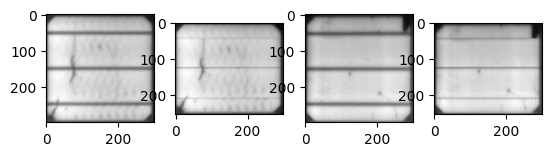

In [ ]:
#check success of preprocessing

fig, axs = plt.subplots(1,4)
axs[0].imshow(dataset_images[0], cmap='gray')
axs[1].imshow(dataset_processed_images[0], cmap='gray')
axs[2].imshow(dataset_images[50], cmap='gray')
axs[3].imshow(dataset_processed_images[50], cmap='gray')

In [ ]:
#some data processing
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Set the directory where the data is stored
data_directory = "C:\\Users\\DOCTOR\\Desktop\\ALL_images\\Artifical\\mono_Processed\\"
#Read the address and merge it into a complete address from the txt file, and import the required data into the matrix.
#If you want to change mono to poly, you only need to change the command address on the path
#data_directory = "C:\\Users\\DOCTOR\\Desktop\\ALL_images\\Artifical\\poly_Processed\\"

# Define the mapping from numeric labels to categories
categories = {
    0.0: "normal",
    0.333333333: "0.3Break",
    0.666666667: "0.6Break",
    1.0: "TotalBreak"
}

# Load the label information from a text file
# label_info = pd.read_csv(
#     "C:\\Users\\DOCTOR\\Desktop\\ALL_images\\labels.txt",
#     delimiter='\t',
#     header=None,
#     names=['image_path', 'label_value', 'image_type']
# )
def map_category(value):
    value_copy = []
    for val in value:
        if val < 0.01:
            value_copy.append("normal")
        elif val < 0.34:
            value_copy.append("0.3Break")
        elif val < 0.67:
            value_copy.append("0.6Break")
        else:
            value_copy.append("TotalBreak")
    return value_copy

# Convert numeric labels to string labels
label_info_label = map_category(probs)

# Initialize list for all images and labels
image_data = []

# Process each image and label
for index, record in enumerate(label_info_label):
    # ?????????????
    # if record['image_type'] != 'mono':
    #     continue  # Skip images that are not of type 'mono'/also could change to "poly"

    # full_image_path = os.path.join(data_directory, record['image_path'])
    image_label = record
    image = dataset_processed_images[index]
    image_type = types[index]
    resized_image = cv2.resize(image, (200, 200))
    image_data.append((resized_image, image_label, image_type))


# Split the data into training and testing sets (80% train, 20% test)
# training_set, testing_set = train_test_split(image_data, test_size=0.2, random_state=42)

# Create mappings for categories to indices
category_indices = {category: idx for idx, category in enumerate(categories.values())}


# Prepare the training and testing datasets
image_set, outcome_categories, type_set  = zip(*[(img, category_indices[lab], type) for img, lab, type in image_data])
# X_test, Y_test_indices, X_test_types = zip(*[(img, category_indices[lab], type) for img, lab, type in testing_set])

# Convert to numpy arrays and normalize
image_set = np.array(image_set).reshape(-1, 200, 200, 1)
# X_test = np.array(X_test).reshape(-1, 200, 200, 1) / 255.0

# Convert labels to one-hot encoding
outcome_categories = to_categorical(outcome_categories, num_classes=len(categories))
# Y_test = to_categorical(Y_test_indices, num_classes=len(categories))

# Print some training labels to ensure the one-hot encoding is correct
print("Sample one-hot encoded training labels:")
for one_hot_label in outcome_categories[50]:
    print(one_hot_label)



Sample one-hot encoded training labels:
0.0
0.0
0.0
1.0


In [ ]:
# create train and test sets

# the dataset is split into 3:
# test: 25% of the dataset used for final evaluation of the mode.

# train: 75% of the dataset used for training the model.
# this is further split into 2:
# agent train: 75% of the train set used for training the agent.
# agent test: 25% of the train set used for evaluating the agent during training and generating a reward.

#input = image, type
#output = probability of damage
X_train, X_test, Y_train, Y_test, type_train, type_test = train_test_split(image_set, outcome_categories, type_set, test_size=0.25, random_state=42)
x_agent_train, x_agent_test, y_agent_train, y_agent_test, type_agent_train, type_agent_test = train_test_split(X_train, Y_train, type_train, test_size=0.25, random_state=42)

# creating a few more defines to suit neural net requirements.

NUM_TRAIN_OUTPUTS = x_agent_train.shape[0]

Section 2: CNN

In [ ]:
#create CNN neural net

from sklearn.metrics import confusion_matrix
import itertools
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Dropout
# from scikeras.wrappers import KerasClassifier, KerasRegressor

def model():
        model = Sequential()

        model.add(Conv2D(filters=8, kernel_size=(3,3), padding='Same', activation='relu', input_shape=(200,200,1)))
        model.add(BatchNormalization())  # Batch Normalization layer
        model.add(Conv2D(filters=16, kernel_size=(3,3), padding='Same', activation='relu'))
        model.add(BatchNormalization())  # Batch Normalization layer
        model.add(MaxPool2D((2,2),strides=(2,2)))

        model.add(Dropout(0.25))

        model.add(Conv2D(filters=32, kernel_size=(3,3), padding='Same', activation='relu'))
        model.add(BatchNormalization())  # Batch Normalization layer


        model.add(Flatten())
        model.add(Dense(64, activation='relu'))
        model.add(Dense(4, activation='sigmoid'))
        optimizer = Adam(learning_rate=0.00002, beta_1=0.85, beta_2=0.98)

        model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
        return model

epochs = 150
batch_size = 32

datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=0.2, # Changed the rotation range
        zoom_range = 0.2,
        width_shift_range=0.2,  # Adjusted the width shift range
        height_shift_range=0.2,  # Adjusted the height shift range
        horizontal_flip=False,
        vertical_flip=False)

In [ ]:
from keras.callbacks import ModelCheckpoint, Callback
import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import tensorflow as tf

In [ ]:
class BestModelCallback(Callback):
    def __init__(self, model):
        super(BestModelCallback, self).__init__()
        self.best_val_accuracy = 0.0
        #at least have a model
        self.best_model = model
        self.best_model_path = ""

    def on_epoch_end(self, epoch, logs=None):
        current_val_accuracy = logs.get("val_accuracy")
        if current_val_accuracy > self.best_val_accuracy:
            self.best_val_accuracy = current_val_accuracy
            self.best_model_path = f'model-best-{epoch:03d}-{current_val_accuracy:.4f}.h5'
            # Save the best model
            self.best_model.save(self.best_model_path)
            print(f"New best model saved: {self.best_model_path}")

Epoch 1/150
61/61 [==============================] - ETA: 0s - loss: 1.1588 - accuracy: 0.5863

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


New best model saved: model-best-000-0.2652.h5
61/61 [==============================] - 12s 104ms/step - loss: 1.1588 - accuracy: 0.5863 - val_loss: 7.9776 - val_accuracy: 0.2652
Epoch 2/150
61/61 [==============================] - 6s 100ms/step - loss: 1.0251 - accuracy: 0.6049 - val_loss: 1.2578 - val_accuracy: 0.5960
Epoch 3/150
61/61 [==============================] - 6s 97ms/step - loss: 1.0048 - accuracy: 0.6322 - val_loss: 1.1540 - val_accuracy: 0.5290
Epoch 4/150
61/61 [==============================] - 6s 91ms/step - loss: 0.9949 - accuracy: 0.6307 - val_loss: 1.1378 - val_accuracy: 0.5305
Epoch 5/150
61/61 [==============================] - 6s 100ms/step - loss: 1.0009 - accuracy: 0.6240 - val_loss: 0.9865 - val_accuracy: 0.6494
Epoch 6/150
61/61 [==============================] - 6s 99ms/step - loss: 1.0051 - accuracy: 0.6224 - val_loss: 0.9900 - val_accuracy: 0.6707
Epoch 7/150
61/61 [==============================] - 6s 93ms/step - loss: 0.9785 - accuracy: 0.6415 - val_los

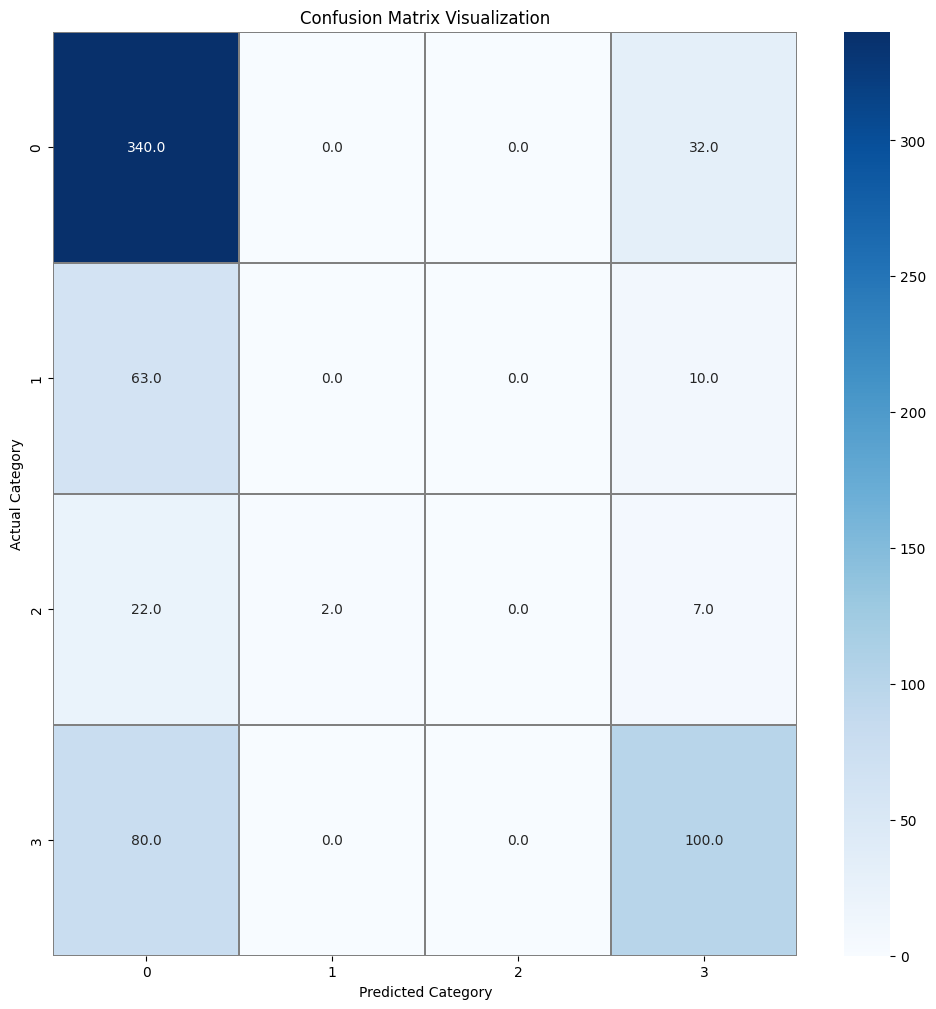

Test Loss: 0.9900481700897217
Test Accuracy: 0.6707317233085632


In [ ]:
# run the CNN model over the train set.
def cnn():
  model = Sequential()

  model.add(Conv2D(filters=8, kernel_size=(3,3), padding='Same', activation='relu', input_shape=(200,200,1)))
  model.add(BatchNormalization())  # Batch Normalization layer
  model.add(Conv2D(filters=16, kernel_size=(3,3), padding='Same', activation='relu'))
  model.add(BatchNormalization())  # Batch Normalization layer
  model.add(MaxPool2D((2,2),strides=(2,2)))

  model.add(Dropout(0.25))

  model.add(Conv2D(filters=32, kernel_size=(3,3), padding='Same', activation='relu'))
  model.add(BatchNormalization())  # Batch Normalization layer


  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dense(4, activation='sigmoid'))
  optimizer = Adam(learning_rate=0.00002, beta_1=0.85, beta_2=0.98)

  model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
  best_model_callback = BestModelCallback(model)

  history = model.fit(datagen.flow(X_train, Y_train, batch_size=batch_size),
                      epochs=epochs,
                      validation_data=(X_test, Y_test),
                      steps_per_epoch=X_train.shape[0] // batch_size,
                      callbacks=[best_model_callback])

  # Ensure the best model was saved
  if best_model_callback.best_model_path:
      # Load the best model
      best_model = keras.models.load_model(best_model_callback.best_model_path)
      print(f"Best model loaded: {best_model_callback.best_model_path}")

      # Predict on test dataset with best model
      test_predictions = best_model.predict(X_test)
      predicted_categories = np.argmax(test_predictions, axis=1)
      true_categories = np.argmax(Y_test, axis=1)

      # Generate confusion matrix
      matrix_of_confusion = confusion_matrix(true_categories, predicted_categories)

      # Plot the confusion matrix
      plt.figure(figsize=(12, 12))
      sns.heatmap(matrix_of_confusion, annot=True, linewidths=0.01, cmap="Blues", linecolor="gray", fmt='.1f')
      plt.xlabel("Predicted Category")
      plt.ylabel("Actual Category")
      plt.title("Confusion Matrix Visualization")
      plt.show()

      # Evaluate the best model
      evaluation = best_model.evaluate(X_test, Y_test, verbose=0)
      print("Test Loss:", evaluation[0])
      print("Test Accuracy:", evaluation[1])
  else:
      print("No best model was saved.")

cnn()

Section 3: Deep Q Learning/ Long Short-Term Memory agent.

In [ ]:
#helper functions

def train_model_once(img, outcome, modelarg):
    """trains model on one image from x_agent_train
    then tests the model on X_train and returns the reward
    """
    # might have to do [img] and [outcome]
    history2 = modelarg.fit(datagen.flow(img, outcome, batch_size=1),
                    epochs=1,
                    steps_per_epoch=1,
                    verbose=0)
    evaluation = modelarg.evaluate(X_train, Y_train, verbose=0)
    accuracy = evaluation[1]
    return accuracy

def get_test_accuracy(modelarg):
    """evaluate the model"""
    evaluation = modelarg.evaluate(X_test, Y_test, verbose=0)
    accuracy = evaluation[1]
    return accuracy


The agent is a deep Q learning agent that utilises a neural net to estimate the value of feeding the CNN an image given a certain state.

It will "play" a game of sequentially feeding the CNN images selectively with the goal of finding the optimal performance of the CNN while preventing overfitting.

The Q learning agent will also utilise and LSTM to remember its previous actions and make decisions based on that.

In [ ]:
#initialize DQL/LSTM neural net

import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)

class Network(nn.Module):
    def __init__(self, lr):
        super(Network, self).__init__()


        self.lstm_input = 3 # 1 for image, 1 for type, 1 for reward ().
        self.lstm_output = 64
        self.inputs = self.lstm_output
        self.hid_1 = 128
        self.hid_2 = 256
        self.n_actions = NUM_TRAIN_OUTPUTS

        #create LSTM module
        self.lstm = nn.LSTM(self.lstm_input, self.lstm_output, 1, batch_first=True)

        # create neural net
        self.model = nn.Sequential(
            nn.Linear(self.inputs, self.hid_1),
            nn.ReLU(),
            nn.Linear(self.hid_1, self.hid_2),
            nn.ReLU(),
            nn.Linear(self.hid_2, self.n_actions),
        )

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.SmoothL1Loss()
        self.device = torch.device('cpu')
        self.to(self.device)

        self.h = torch.zeros(1, 1, self.lstm_output).to(self.device)
        self.c = torch.zeros(1, 1, self.lstm_output).to(self.device)

    def forward(self, x, h_0=np.array(42), c_0=np.array(42),  zero=False, use_args=False):
        if use_args:
            self.h = h_0.to(self.device)
            self.c = c_0.to(self.device)
        if zero:
            self.h = torch.zeros(1, x.size(0), self.lstm_output).to(self.device)
            self.c = torch.zeros(1, x.size(0), self.lstm_output).to(self.device)

        x = x.type(torch.FloatTensor).to(self.device)
        lstm_output, (self.h, self.c) = self.lstm(x.view(len(x), 1, 3), (self.h, self.c))  #define strict lstm input of [[image, type, reward]]

        output = self.model(lstm_output.view(len(x), -1))
        return output, (self.h.clone().detach().requires_grad_(True), self.c.clone().detach().requires_grad_(True))

    def zero(self, x):
        self.h = torch.zeros(1, x.size(0), self.lstm_output).to(self.device)
        self.c = torch.zeros(1, x.size(0), self.lstm_output).to(self.device)


In [ ]:
#initialize the agent who acts, remmebers and learns.

class Agent(object):
    def __init__(self):
        """
        Porperties:
            gamma (float): Future reward discount rate.
            epsilon (float): Probability for choosing random policy.
            epsilon_decay (float): Rate at which epsilon decays toward zero.
            learning_rate (float): Learning rate for Adam optimizer.

        Returns:
            Agent
        """
        # constant parameters
        self.gamma = 0.5
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.9
        self.lr = 0.01
        self.batch_size = 20
        self.max_mem_size = 5000

        #variable parameters
        self.epsilon = 0.9
        self.mem_cntr = 0
        self.mem_cntr_successful = 0

        # initializing memory
        self.memory = deque(maxlen=self.max_mem_size)
        self.memory_successful = deque(maxlen=1000)
        self.episodic_memory = []

        #initialize networks
        self.network = Network(self.lr)

    def getMemory(self):
        return self.memory

    def nextEpisode(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def getepsilon(self):
        return self.epsilon

    def remember(self, state, h_0, c_0, action, reward, next_state, terminal, h_1, c_1):
        if (self.mem_cntr >= self.max_mem_size - 2):
            for i in range(self.max_mem_size - 500):
                self.memory.popleft()
            self.mem_cntr = len(self.memory)

        memory = [state, h_0, c_0, action, reward, next_state, terminal, h_1, c_1]
        self.memory.append(memory)

        self.mem_cntr += 1

    #state consists of [previous_image, previous_type, previous_reward]
    def select_action(self, state, zero=False):
        # state = torch.tensor([state])
        #select epsilon-greedy action
        output, (h_0, c_0) = self.network.forward(state, zero=zero)
        action = torch.argmax(output).item()
        if np.random.rand() <= self.epsilon:
            # exploration
            action = np.random.randint(0, NUM_TRAIN_OUTPUTS - 1);
        return action, h_0, c_0

    def updateEpsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def updateEpsilonScore(self, score):
        modifier = -0.01*score + 1.08
        episolon_new = min(self.epsilon * modifier, 0.7 )
        self.epsilon = max(self.epsilon_min, episolon_new)

    def learn(self):
        if self.mem_cntr < self.batch_size:
            return

        max_mem = min(self.mem_cntr, self.max_mem_size)

        #select a random set of states
        batch = np.random.choice(max_mem, self.batch_size, replace=False)

        # memory = [state, h_0, c_0, action, reward, next_state, terminal, h_1, c_1]
        #state consists of [previous_image, previous_type, previous_reward]

        for i in batch:
            state = self.memory[i][0].to(self.network.device, dtype=torch.float32)
            h_0 = self.memory[i][1]
            c_0 = self.memory[i][2]
            action = torch.tensor([self.memory[i][3]])
            reward = torch.tensor([self.memory[i][4]]).to(self.network.device, dtype=torch.float32)
            next_state = self.memory[i][5].to(self.network.device, dtype=torch.float32)
            terminal = torch.tensor([self.memory[i][6]]).to(self.network.device, dtype=torch.bool)
            h_1 = self.memory[i][7]
            c_1 = self.memory[i][8]


            q_current_arr, _ = self.network.forward(state, h_0, c_0, use_args=True)
            q_current = q_current_arr[0][action]
            q_next, _ = self.network.forward(next_state, h_1, c_1, use_args=True)
            if terminal:
                q_next = reward
            q_target = reward + self.gamma * torch.max(q_next)
            self.network.optimizer.zero_grad()
            loss = self.network.loss(q_target, q_current).to(self.network.device)
            loss.backward()
            torch.nn.utils.clip_grad_value_(self.network.parameters(), 100)
            self.network.optimizer.step()

    def update_episodic_memory(self, state, action, reward, next_state, done, current_step):
        self.episodic_memory.append([state, action, reward, next_state, done, 0])

In [ ]:
#creating the CNN for the agent to work with

classifier = Sequential()

classifier.add(Conv2D(filters=8, kernel_size=(3,3), padding='Same', activation='relu', input_shape=(200,200,1)))
classifier.add(BatchNormalization())  # Batch Normalization layer
classifier.add(Conv2D(filters=16, kernel_size=(3,3), padding='Same', activation='relu'))
classifier.add(BatchNormalization())  # Batch Normalization layer
classifier.add(MaxPool2D((2,2),strides=(2,2)))

classifier.add(Dropout(0.25))

classifier.add(Conv2D(filters=32, kernel_size=(3,3), padding='Same', activation='relu'))
classifier.add(BatchNormalization())  # Batch Normalization layer


classifier.add(Flatten())
classifier.add(Dense(64, activation='relu'))
classifier.add(Dense(4, activation='sigmoid'))
optimizer = Adam(learning_rate=1e-4, beta_1=0.85, beta_2=0.98)

classifier.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

#we want to start with the same weights every time
classifier.save_weights('my_model_weights.h5')

In [ ]:
#main training loop for the RL agent
import pickle
from keras.models import clone_model

def train(n_games):

    agent = Agent()
    scores, avg_scores, eps_history, actions_arr = [], [], [], []

    for game in range(n_games):
        # initialize new CNN
        classifier.load_weights('my_model_weights.h5')
        # score is portion of things the image classifier got right on the train set.
        score = train_model_once(x_agent_train[0:1], y_agent_train[0:1], classifier)
        game_over = False
        #state consists of [previous_image, previous_type, previous_reward]
        state = torch.tensor([[0, int(type_agent_train[0]), 0]])
        # zero hidden network state for consistent results.
        agent.network.zero(state)
        h_0, c_0 = agent.network.h, agent.network.c
        terminal = False
        # memory = [state, h_0, c_0, action, reward, next_state, h_1, c_1, terminal]
        score_arr, reward_arr = [], []
        for step in range(25):
            if step % 5 == 0:
                print('episode: ', game, 'step: ', step, 'score: %.2f' % score)
            if step == 25 - 1:
                terminal = True
            #during training, the agent is only able to select a random action from the agent_train set. zero the LSTM for first run.
            action, h_1, c_1 = agent.select_action(state)
            zero = False
            # train the image classifier on the action
            new_score = train_model_once(x_agent_train[action: action+1], y_agent_train[action: action+1], classifier)
            # get the reward
            reward = (new_score - score) * 50
            score = new_score
            # record the "next state"
            # print([action, type_agent_train[action], reward])
            next_state = torch.tensor([[action, int(type_agent_train[action]), reward]])
            # add to memory
            agent.remember(state, h_0.clone().detach().requires_grad_(True), c_0.clone().detach().requires_grad_(True), action, reward, next_state, terminal, h_1.clone().detach().requires_grad_(True), c_1.clone().detach().requires_grad_(True))
            # update states
            state = next_state
            h_0 = h_1
            c_0 = c_1
            # add stats to score and reward array for plotting
            score_arr.append(score)
            reward_arr.append(reward)
            actions_arr.append(action)
            # if step % 200 == 0:
            #   agent.learn()
        #after each "game", lean from 1000 random experiences.
        agent.learn()
        #reduce change of random action.
        agent.updateEpsilon()
        avg_scores.append(score_arr[-1])
        avg_score = np.mean(avg_scores[-10:])
        true_score = get_test_accuracy(classifier)
        scores, eps_history, actions_arr = [], [], []
        print('episode: ', game,'score: %.2f' % score_arr[-1],
                ' avg score %.2f' % avg_score, 'epsilon %.2f' % agent.epsilon, 'true score %.2f' % true_score)
        # if (keyboard.is_pressed("`")):
        #     break

    plt.plot(avg_scores)
    plt.show()

In [ ]:
#run the training loop
train(200)

episode:  0 step:  0 score: 0.11
episode:  0 step:  5 score: 0.11
episode:  0 step:  10 score: 0.11
episode:  0 step:  15 score: 0.11
episode:  0 step:  20 score: 0.12
episode:  0 score: 0.19  avg score 0.19 epsilon 0.81 true score 0.19
episode:  1 step:  0 score: 0.11
episode:  1 step:  5 score: 0.11
episode:  1 step:  10 score: 0.12
episode:  1 step:  15 score: 0.11
episode:  1 step:  20 score: 0.08
episode:  1 score: 0.24  avg score 0.22 epsilon 0.73 true score 0.25
episode:  2 step:  0 score: 0.14
episode:  2 step:  5 score: 0.11
episode:  2 step:  10 score: 0.11
episode:  2 step:  15 score: 0.13
episode:  2 step:  20 score: 0.34
episode:  2 score: 0.44  avg score 0.29 epsilon 0.66 true score 0.45
episode:  3 step:  0 score: 0.11
episode:  3 step:  5 score: 0.11
episode:  3 step:  10 score: 0.12
episode:  3 step:  15 score: 0.13
episode:  3 step:  20 score: 0.16
episode:  3 score: 0.21  avg score 0.27 epsilon 0.59 true score 0.22
episode:  4 step:  0 score: 0.27
episode:  4 step:  

ResourceExhaustedError: ignored